In [27]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [28]:
ee.Initialize()

In [29]:
"""Composite an image collection and clip it to a boundary from a fusion table.
See also: Filtered Seasonal Composite, which filters the
collection by bounds instead.
"""

# Clip to the output image to the California state boundary.
area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8')
      .filter(ee.Filter().eq('Name', 'California')))


# area = (ee.FeatureCollection('ft:15lPINLDEkEApjBba2zZtB7tCjef9banI2m90IrYA')
#       .filter(ee.Filter().eq('COUNTY num', 107)))

# area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter().eq('id', '105')))

# area =  ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')


# import the RS products
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
#modis = ee.ImageCollection('MODIS/MOD13Q1') #MCD43A4_NDVI
modis = ee.ImageCollection('MCD43A4_NDVI') #
 
# Define time range
#startyear = 2000
#endyear = 2017

years = [x for x in range(2000, 2016)]

In [30]:
# Functions

def filter_date_chirps(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,12,31)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("precipitation")
    return prod
    
def filter_date_modis(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("NDVI")
    return prod

def aggregate(product,year):

    # Filter
    filtered = filter_date_modis(product, year)

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(2,9)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    seasonal = ee.ImageCollection(calcMean(filtered, year))

    # select the region of interest, 25000 is the cellsize in meters
    seasonal = seasonal.getRegion(area,5000,"epsg:4326").getInfo()

    return seasonal 

def make_df_from_imcol(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df.NDVI)
    
    return lons, lats, data
    return df

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

In [31]:
finals_modis = []

for year in years:
    finals_modis.append(aggregate(modis,year))


In [32]:
fin_modis_dfs = []
for i in finals_modis:
    fin_modis_dfs.append(df_from_ee_object(i))
    

In [33]:
# PLOT MAPS

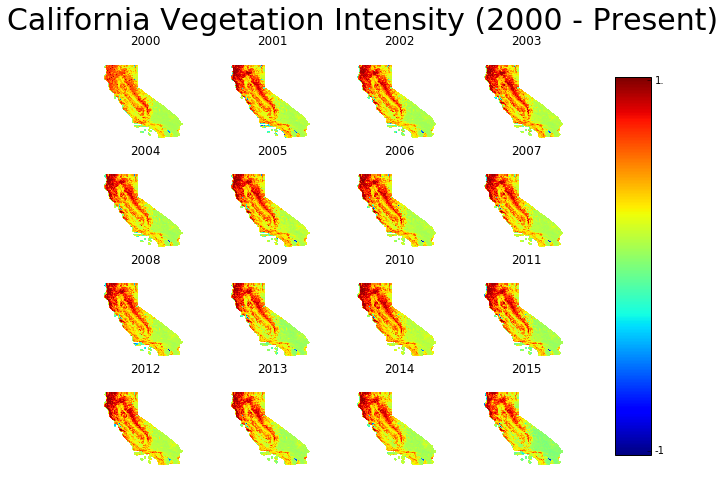

In [34]:
#del(fig,axs)
fig, axs = plt.subplots(4,4, figsize=(10,7.5))
axs = axs.ravel()

plt.suptitle('California Vegetation Intensity (2000 - Present)', size = 30)

for i in range(len(fin_modis_dfs)):
    
    a = axs[i].scatter(fin_modis_dfs[i]['longitude'],fin_modis_dfs[i]['latitude'],marker = "s",c = fin_modis_dfs[i]['NDVI'],s= 2, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(a, cax=cbar_ax)
cb.set_ticks([18000,-1400])
cb.set_ticks([3.5,-2.9])
cb.set_ticklabels(["1.","-1"])

plt.show()

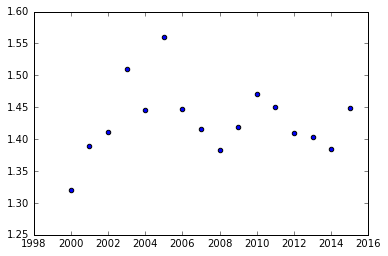

In [21]:
# Scatterplot
annual_avgs = dict(zip(years,[np.mean(df['NDVI']) for df in fin_modis_dfs]))
plt.scatter(annual_avgs.keys(), annual_avgs.values())
plt.show()

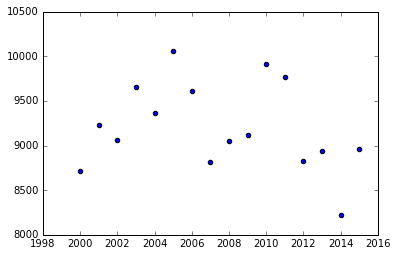

In [21]:
annual_avgs = dict(zip(years,[np.mean(df['NDVI']) for df in fin_modis_dfs]))
plt.scatter(annual_avgs.keys(), annual_avgs.values())
plt.show()


In [22]:
finals_chirps = []
for year in years:
    finals_chirps.append(aggregate_chirps(chirps,year))

NameError: name 'aggregate_chirps' is not defined

In [ ]:
fin_chirps_dfs = []
for i in finals_chirps:
    fin_chirps_dfs.append(df_from_ee_object(i))

In [ ]:
plt.scatter(fin_dfs[10][0], fin_dfs[10][1], c = fin_dfs[10][2])
plt.show()

In [ ]:
plt.scatter(fin_dfs[1][0], fin_dfs[1][1], c = fin_dfs[1][2])
plt.show()

In [ ]:
dfs_by_year = dict(zip(years,fin_modis_dfs))

for k,v in dfs_by_year.items():
    path = os.path.join(os.getcwd(), "modis_data")
    v.to_csv(os.path.join(path,str(k)+".csv"))

In [ ]:
chirps_by_year = dict(zip(years,fin_chirps_dfs))
for k,v in chirps_by_year.items():
    path = os.path.join(os.getcwd(), "chirps_csvs")
    v.to_csv(os.path.join(path,str(k)+"_.csv"))

In [ ]:
os.getcwd()

In [ ]:
os.listdir(os.getcwd())